## Bollinger Bands Mean Reversion Strategy

In [53]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [54]:
EURUSD = yf.download("EURUSD=x", start = "2006-01-01", end = "2022-09-06")
data = pd.DataFrame()
data["price"] = EURUSD["Close"]

[*********************100%***********************]  1 of 1 completed


In [55]:
data

,price
Date,
2006-01-02,1.181698
2006-01-03,1.203297
2006-01-04,1.211196
2006-01-05,1.210698
2006-01-06,1.215407
...,...
2022-08-30,1.001402
2022-08-31,1.002506
2022-09-01,1.003905


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4324 entries, 2006-01-02 to 2022-09-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4324 non-null   float64
dtypes: float64(1)
memory usage: 67.6 KB


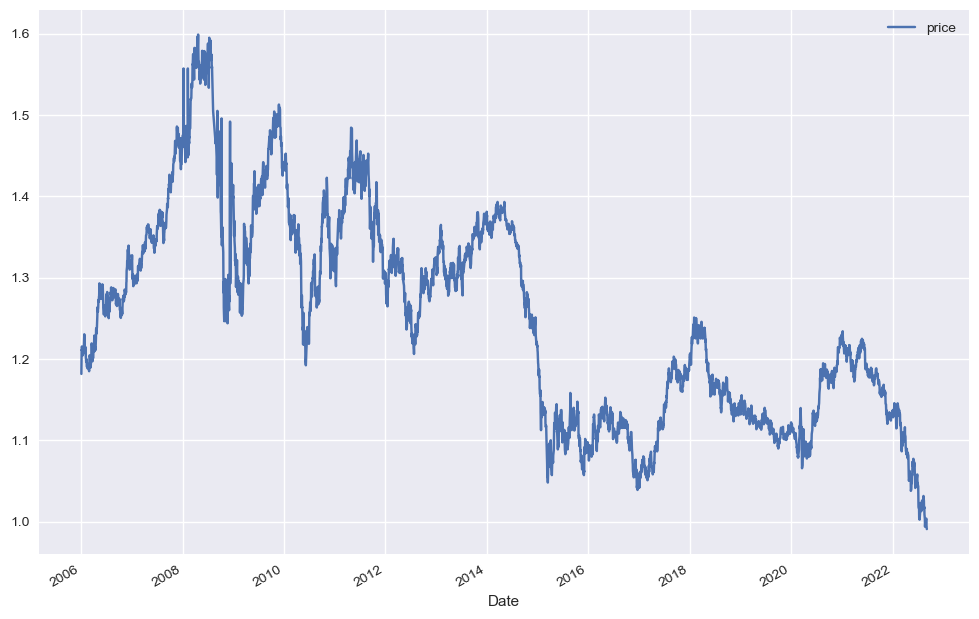

In [57]:
data.plot(figsize = (12, 8))
plt.show()

# making the strategy

In [58]:
data["returns"] = np.log(data.div(data.shift(1)))

In [59]:
data

,price,returns
Date,,
2006-01-02,1.181698,NaN
2006-01-03,1.203297,0.018113
2006-01-04,1.211196,0.006543
2006-01-05,1.210698,-0.000412
2006-01-06,1.215407,0.003882
...,...,...
2022-08-30,1.001402,0.007552
2022-08-31,1.002506,0.001102
2022-09-01,1.003905,0.001394


In [60]:
SMA = 30 # days
dev = 2

In [61]:
data["SMA"] = data["price"].rolling(SMA).mean()

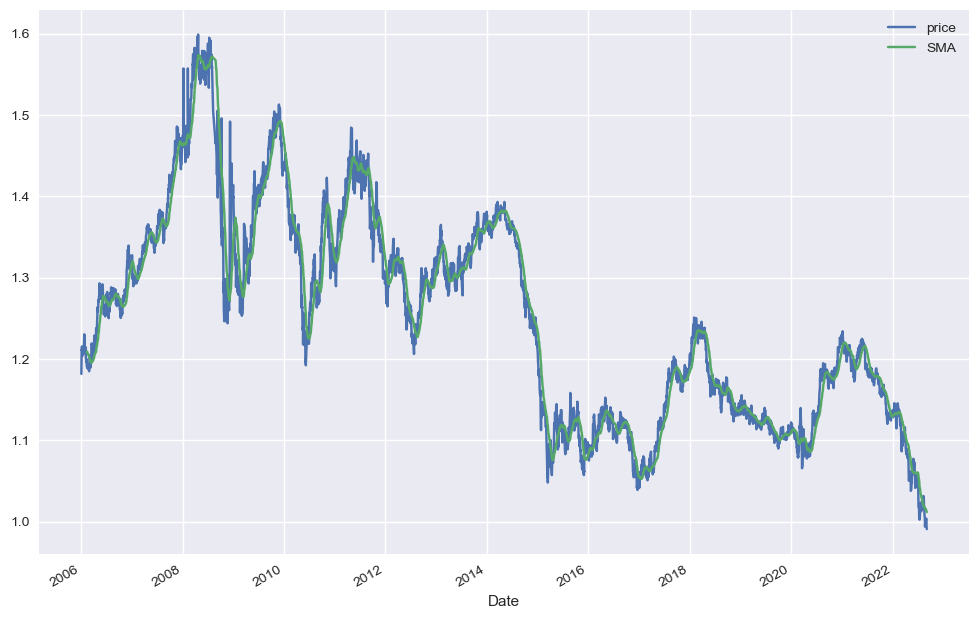

In [62]:
data[["price", "SMA"]].plot(figsize = (12, 8))
plt.show()

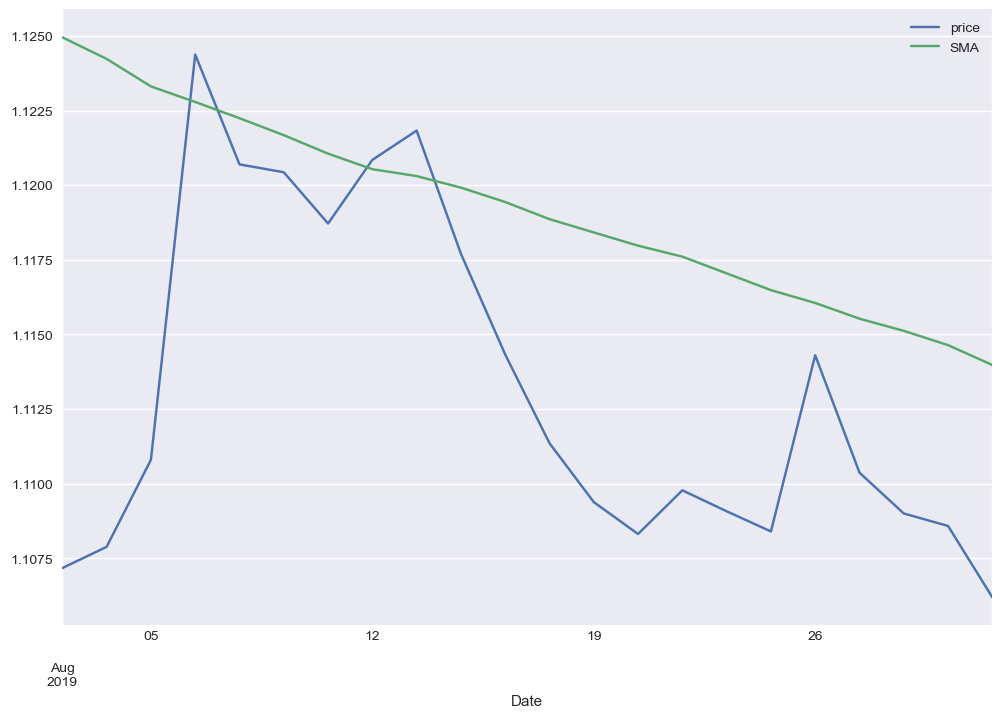

In [63]:
data.loc["2019-08", ["price", "SMA"]].plot(figsize = (12, 8))
plt.show()

In [64]:
data["price"].rolling(SMA).std()

Date
2006-01-02         NaN
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
                ...   
2022-08-30    0.010890
2022-08-31    0.011012
2022-09-01    0.011146
2022-09-02    0.011535
2022-09-05    0.012128
Name: price, Length: 4324, dtype: float64

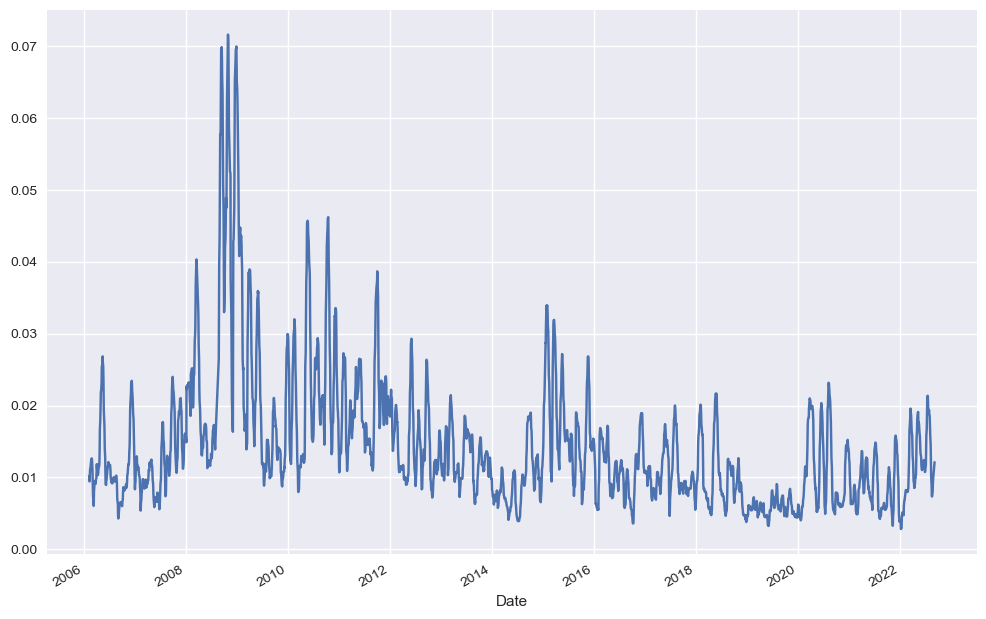

In [65]:
data["price"].rolling(SMA).std().plot(figsize = (12, 8))
plt.show()

In [66]:
data["Lower"] = data["SMA"] - data["price"].rolling(SMA).std() * dev # Lower Band -2 Std Dev

In [67]:
data["Upper"] = data["SMA"] + data["price"].rolling(SMA).std() * dev # Upper Band -2 Std Dev

In [68]:
data

,price,returns,SMA,Lower,Upper
Date,,,,,
2006-01-02,1.181698,NaN,NaN,NaN,NaN
2006-01-03,1.203297,0.018113,NaN,NaN,NaN
2006-01-04,1.211196,0.006543,NaN,NaN,NaN
2006-01-05,1.210698,-0.000412,NaN,NaN,NaN
2006-01-06,1.215407,0.003882,NaN,NaN,NaN
...,...,...,...,...,...
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160


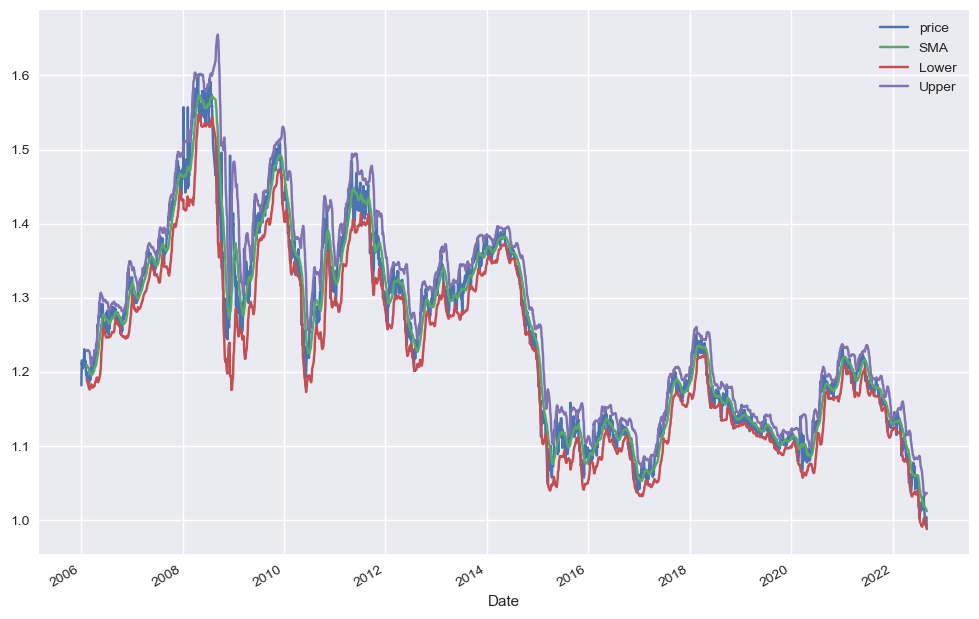

In [69]:
data.drop(columns = "returns").plot(figsize = (12, 8))
plt.show()

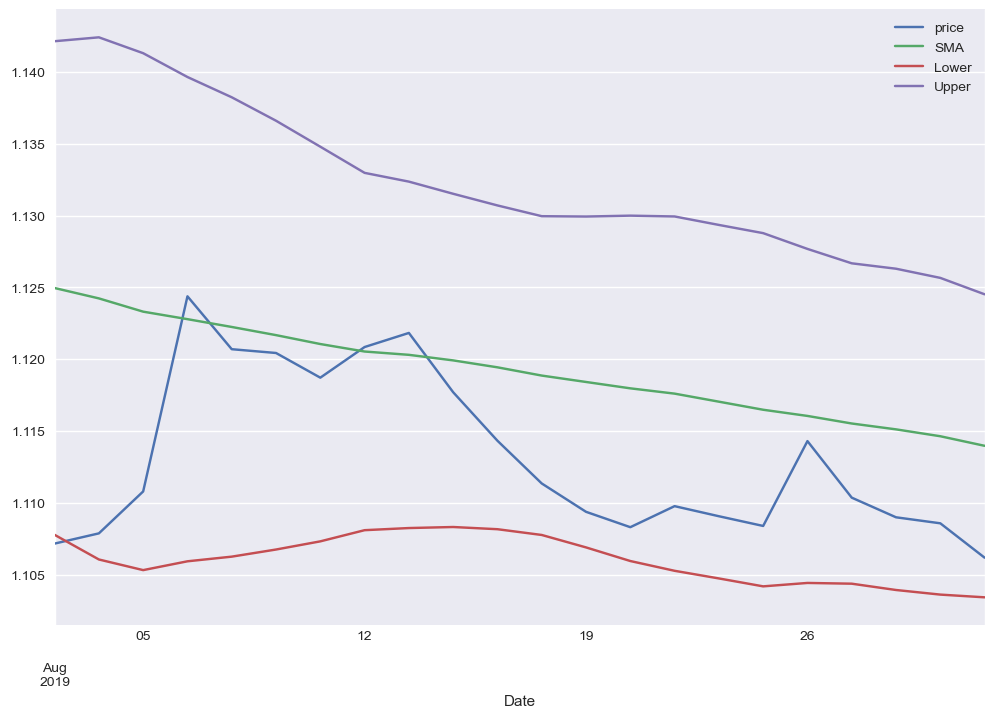

In [70]:
data.drop(columns = "returns").loc["2019-08"].plot(figsize = (12, 8))
plt.show()

In [71]:
data["distance"] = data.price - data.SMA # helper Column

In [72]:
data.dropna(inplace = True)
data

,price,returns,SMA,Lower,Upper,distance
Date,,,,,,
2006-02-10,1.190703,-0.007278,1.208687,1.188281,1.229092,-0.017984
2006-02-13,1.191199,0.000417,1.209004,1.190091,1.227916,-0.017804
2006-02-14,1.191597,0.000334,1.208613,1.188755,1.228472,-0.017017
2006-02-15,1.188594,-0.002523,1.207860,1.186733,1.228987,-0.019266
2006-02-16,1.190703,0.001773,1.207194,1.185193,1.229194,-0.016491
...,...,...,...,...,...,...
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814,-0.013632
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370,-0.011840
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160,-0.009962


In [73]:
data["position"] = np.where(data.price < data.Lower, 1, np.nan) # 1. oversold -> go long

In [74]:
data["position"] = np.where(data.price > data.Upper, -1, data["position"]) # 2. overbought -> go short

when it crosses the SMA, it closes the position (sets to 0)

In [75]:
data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])

In [76]:
data

,price,returns,SMA,Lower,Upper,distance,position
Date,,,,,,,
2006-02-10,1.190703,-0.007278,1.208687,1.188281,1.229092,-0.017984,NaN
2006-02-13,1.191199,0.000417,1.209004,1.190091,1.227916,-0.017804,NaN
2006-02-14,1.191597,0.000334,1.208613,1.188755,1.228472,-0.017017,NaN
2006-02-15,1.188594,-0.002523,1.207860,1.186733,1.228987,-0.019266,NaN
2006-02-16,1.190703,0.001773,1.207194,1.185193,1.229194,-0.016491,NaN
...,...,...,...,...,...,...,...
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814,-0.013632,NaN
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370,-0.011840,NaN
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160,-0.009962,NaN


In [77]:
data["position"] = data.position.ffill().fillna(0) # where 1-3 isn´t applicable -> hold previous position

In [78]:
data

,price,returns,SMA,Lower,Upper,distance,position
Date,,,,,,,
2006-02-10,1.190703,-0.007278,1.208687,1.188281,1.229092,-0.017984,0.0
2006-02-13,1.191199,0.000417,1.209004,1.190091,1.227916,-0.017804,0.0
2006-02-14,1.191597,0.000334,1.208613,1.188755,1.228472,-0.017017,0.0
2006-02-15,1.188594,-0.002523,1.207860,1.186733,1.228987,-0.019266,0.0
2006-02-16,1.190703,0.001773,1.207194,1.185193,1.229194,-0.016491,0.0
...,...,...,...,...,...,...,...
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814,-0.013632,1.0
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370,-0.011840,1.0
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160,-0.009962,1.0


In [79]:
data.position.value_counts()

 0.0    1925
 1.0    1215
-1.0    1155
Name: position, dtype: int64

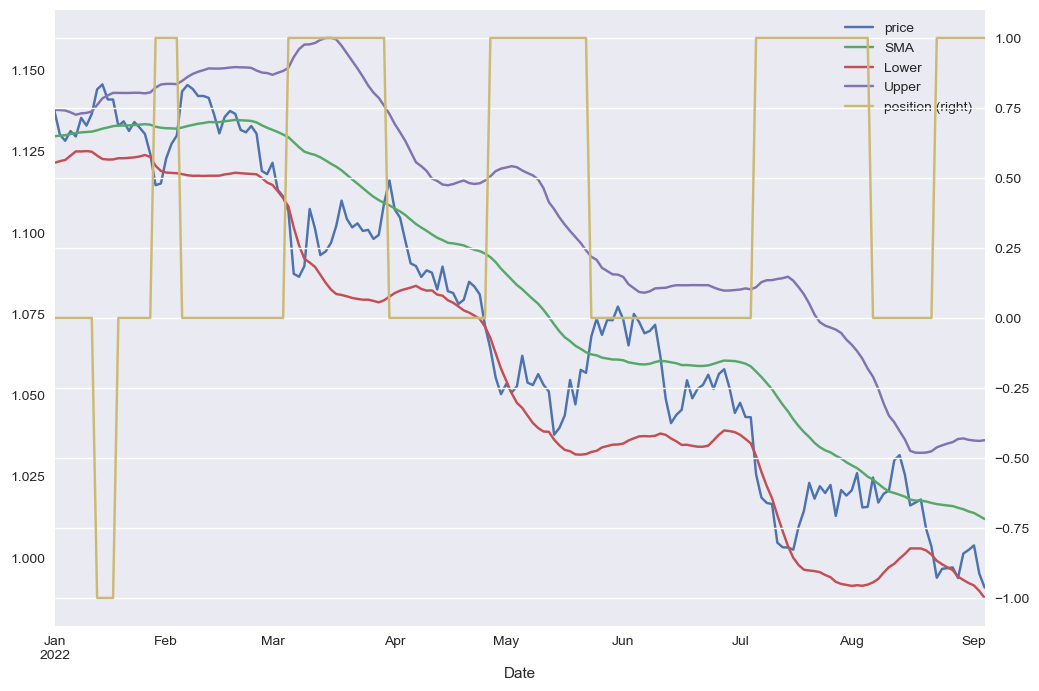

In [80]:
data.drop(columns = ["returns", "distance"]).loc["2022"].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

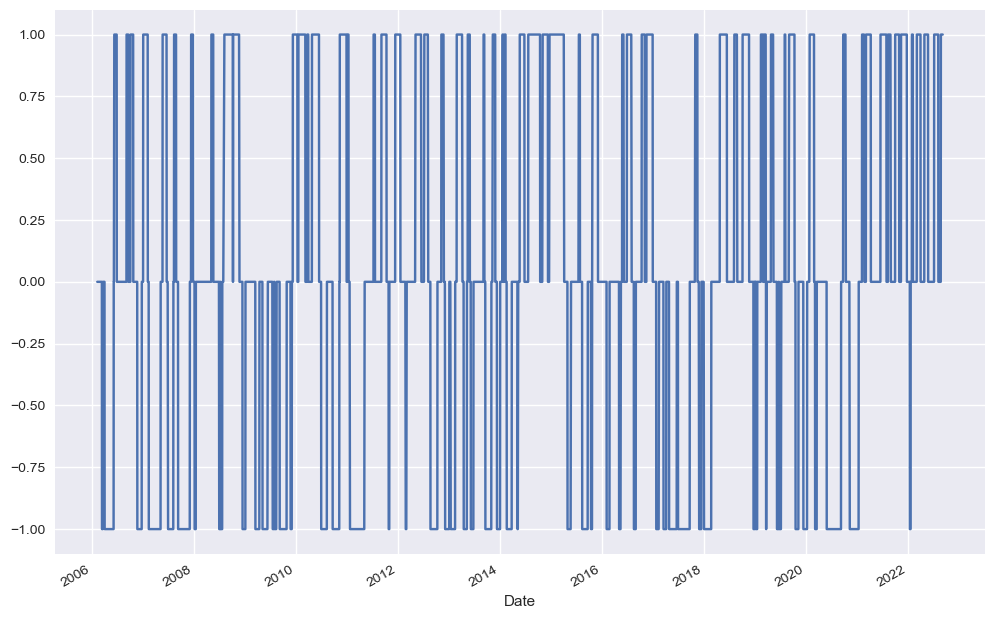

In [81]:
data.position.plot(figsize = (12, 8))
plt.show()

In [82]:
def test_strategy2(data):
    data["strategy"] = data.position.shift(1) * data["returns"]
    data.dropna(inplace = True)

    annual_means = data[["returns", "strategy"]].mean() * 252
    annual_stds = data[["returns", "strategy"]].std() * np.sqrt(252)
    
    return np.exp(data["strategy"].sum())

In [83]:
test_strategy2(data)

1.1237556636244497

this closes the last position if it hasn't been closed

In [84]:
data["position"][-1] = 0

In [85]:
data.tail()

,price,returns,SMA,Lower,Upper,distance,position,strategy
Date,,,,,,,,
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814,-0.013632,1.0,0.007552
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370,-0.011840,1.0,0.001102
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160,-0.009962,1.0,0.001394
2022-09-02,0.995233,-0.008676,1.012972,0.989903,1.036041,-0.017739,1.0,-0.008676
2022-09-05,0.990943,-0.004320,1.012002,0.987746,1.036259,-0.021060,0.0,-0.004320


In [86]:
def strategy3(data):
    data["Trade"] = data["position"] - data["position"].shift(1)
    data["Cost_of_Execution"] = data["Trade"] * data["price"]
    print(data)

    return -data["Cost_of_Execution"].sum()

if the return value of this function is negative then it means you have made money, as say you bought at 1.0 and sold for 1.2, then the maths in the table is 1.0 + (-1.2) = -0.2 so I have made a profit of 0.2

In [87]:
PnL = strategy3(data)
PnL

               price   returns       SMA     Lower     Upper  distance  \
Date                                                                     
2006-02-13  1.191199  0.000417  1.209004  1.190091  1.227916 -0.017804   
2006-02-14  1.191597  0.000334  1.208613  1.188755  1.228472 -0.017017   
2006-02-15  1.188594 -0.002523  1.207860  1.186733  1.228987 -0.019266   
2006-02-16  1.190703  0.001773  1.207194  1.185193  1.229194 -0.016491   
2006-02-17  1.194201  0.002933  1.206487  1.184217  1.228756 -0.012286   
...              ...       ...       ...       ...       ...       ...   
2022-08-30  1.001402  0.007552  1.015034  0.993254  1.036814 -0.013632   
2022-08-31  1.002506  0.001102  1.014347  0.992324  1.036370 -0.011840   
2022-09-01  1.003905  0.001394  1.013868  0.991575  1.036160 -0.009962   
2022-09-02  0.995233 -0.008676  1.012972  0.989903  1.036041 -0.017739   
2022-09-05  0.990943 -0.004320  1.012002  0.987746  1.036259 -0.021060   

            position  strategy  Trade

0.1680639386177063

Now to calculate PnL

In [96]:
def PnL(df):
    df["PnL"] = np.nan
    current_position = 0
    position_price = 0

    for i in df.index:
        if (df["position"][i] == 1.0) & (current_position == 0):
            current_position = 1
            position_price = df["price"][i]
        elif (df["position"][i] == -1.0) & (current_position == 0):
            current_position = -1
            position_price = df["price"][i]
        elif df["position"][i] == 0.0:
            if current_position == 1:
                PnL = df["price"][i] - position_price
                df["PnL"][i] = PnL
                current_position = 0
            elif current_position == -1:
                PnL = position_price - df["price"][i]
                df["PnL"][i] = PnL
                current_position = 0

doesn't use function above but function above does the job

In [88]:
data["PnL"] = np.nan
current_position = 0
position_price = 0

for i in data.index:
    if (data["position"][i] == 1.0) & (current_position == 0):
        current_position = 1
        position_price = data["price"][i]
    elif (data["position"][i] == -1.0) & (current_position == 0):
        current_position = -1
        position_price = data["price"][i]
    elif data["position"][i] == 0.0:
        if current_position == 1:
            PnL = data["price"][i] - position_price
            data["PnL"][i] = PnL
            current_position = 0
        elif current_position == -1:
            PnL = position_price - data["price"][i]
            data["PnL"][i] = PnL
            current_position = 0
data

,price,returns,SMA,Lower,Upper,distance,position,strategy,Trade,Cost_of_Execution,PnL
Date,,,,,,,,,,,
2006-02-13,1.191199,0.000417,1.209004,1.190091,1.227916,-0.017804,0.0,0.000000,NaN,NaN,NaN
2006-02-14,1.191597,0.000334,1.208613,1.188755,1.228472,-0.017017,0.0,0.000000,0.0,0.000000,NaN
2006-02-15,1.188594,-0.002523,1.207860,1.186733,1.228987,-0.019266,0.0,-0.000000,0.0,0.000000,NaN
2006-02-16,1.190703,0.001773,1.207194,1.185193,1.229194,-0.016491,0.0,0.000000,0.0,0.000000,NaN
2006-02-17,1.194201,0.002933,1.206487,1.184217,1.228756,-0.012286,0.0,0.000000,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,1.001402,0.007552,1.015034,0.993254,1.036814,-0.013632,1.0,0.007552,0.0,0.000000,NaN
2022-08-31,1.002506,0.001102,1.014347,0.992324,1.036370,-0.011840,1.0,0.001102,0.0,0.000000,NaN
2022-09-01,1.003905,0.001394,1.013868,0.991575,1.036160,-0.009962,1.0,0.001394,0.0,0.000000,NaN


In [111]:
buysignals = data[data["Trade"]==1.0].loc["2019"].index.values
sellsignals = data[data["Trade"]==-1.0].loc["2019"].index.values

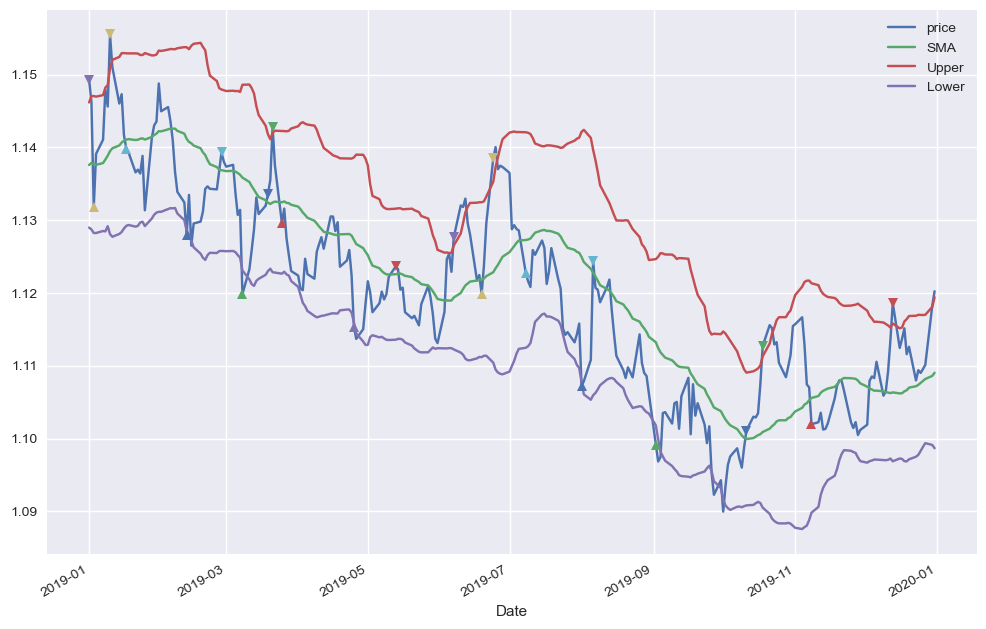

In [113]:
data[["price", "SMA", "Upper", "Lower"]].loc["2019"].plot(figsize=(12,8))
for id in buysignals:
    plt.plot(id, data["price"][id], "^")
for id in sellsignals:
    plt.plot(id, data["price"][id], "v")
plt.show()


make a df with just the PnL values

In [89]:
PnLdf = data.dropna()
PnLdf

,price,returns,SMA,Lower,Upper,distance,position,strategy,Trade,Cost_of_Execution,PnL
Date,,,,,,,,,,,
2006-03-23,1.197203,-0.008899,1.197397,1.178519,1.216275,-0.000194,0.0,0.008899,1.0,1.197203,0.020290
2006-06-08,1.264894,-0.012025,1.277352,1.259292,1.295412,-0.012458,0.0,0.012025,1.0,1.264894,-0.038893
2006-06-30,1.278298,0.009352,1.270170,1.246397,1.293943,0.008128,0.0,0.009352,-1.0,-1.278298,0.019693
2006-09-21,1.278102,0.007310,1.276895,1.264087,1.289704,0.001207,0.0,0.007310,-1.0,-1.278102,0.010804
2006-10-26,1.269406,0.006163,1.264357,1.247598,1.281116,0.005049,0.0,0.006163,-1.0,-1.269406,0.009008
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,1.143576,0.011947,1.132447,1.118108,1.146785,0.011129,0.0,0.011947,-1.0,-1.143576,0.028873
2022-03-31,1.116184,0.006320,1.108516,1.080411,1.136621,0.007668,0.0,0.006320,-1.0,-1.116184,0.009499
2022-05-24,1.068205,0.010562,1.062661,1.032647,1.092675,0.005544,0.0,0.010562,-1.0,-1.068205,0.003843


In [90]:
PnL = data["PnL"].sum()
PnL

0.1680639386177063

plot of PnL

<AxesSubplot:xlabel='Date'>

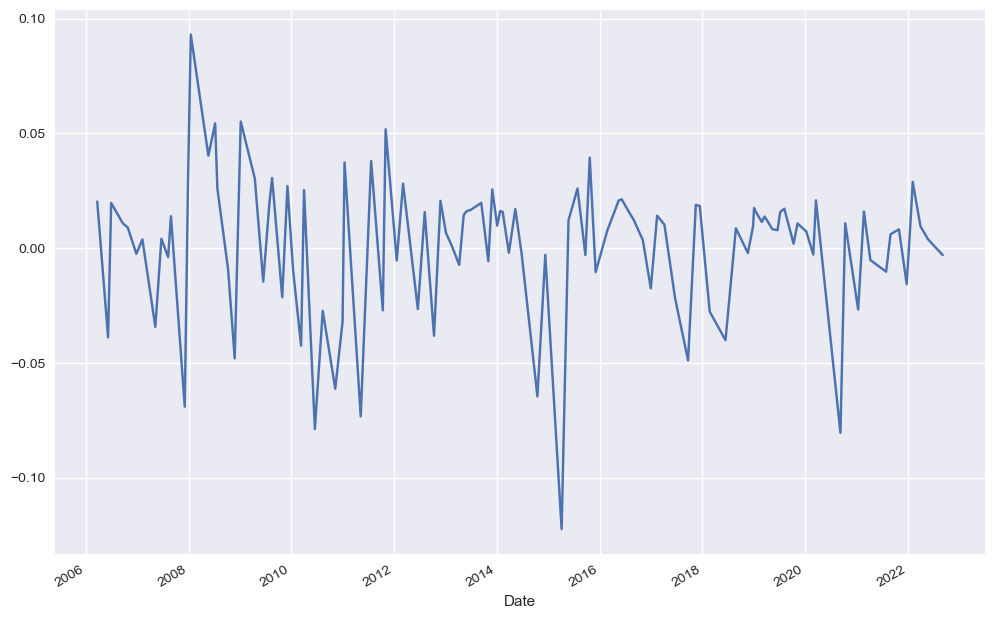

In [91]:
PnLdf["PnL"].plot(figsize=(12,8))

In [92]:
PnLdf["cumPnL"] = PnLdf["PnL"].cumsum()
PnLdf

/var/folders/ym/zxt7rwrx44s222zyh_0_7d6w0000gn/T/ipykernel_4098/2797863746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PnLdf["cumPnL"] = PnLdf["PnL"].cumsum()


,price,returns,SMA,Lower,Upper,distance,position,strategy,Trade,Cost_of_Execution,PnL,cumPnL
Date,,,,,,,,,,,,
2006-03-23,1.197203,-0.008899,1.197397,1.178519,1.216275,-0.000194,0.0,0.008899,1.0,1.197203,0.020290,0.020290
2006-06-08,1.264894,-0.012025,1.277352,1.259292,1.295412,-0.012458,0.0,0.012025,1.0,1.264894,-0.038893,-0.018603
2006-06-30,1.278298,0.009352,1.270170,1.246397,1.293943,0.008128,0.0,0.009352,-1.0,-1.278298,0.019693,0.001089
2006-09-21,1.278102,0.007310,1.276895,1.264087,1.289704,0.001207,0.0,0.007310,-1.0,-1.278102,0.010804,0.011893
2006-10-26,1.269406,0.006163,1.264357,1.247598,1.281116,0.005049,0.0,0.006163,-1.0,-1.269406,0.009008,0.020901
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,1.143576,0.011947,1.132447,1.118108,1.146785,0.011129,0.0,0.011947,-1.0,-1.143576,0.028873,0.158714
2022-03-31,1.116184,0.006320,1.108516,1.080411,1.136621,0.007668,0.0,0.006320,-1.0,-1.116184,0.009499,0.168213
2022-05-24,1.068205,0.010562,1.062661,1.032647,1.092675,0.005544,0.0,0.010562,-1.0,-1.068205,0.003843,0.172056


Plot of Cumulative PnL

<AxesSubplot:xlabel='Date'>

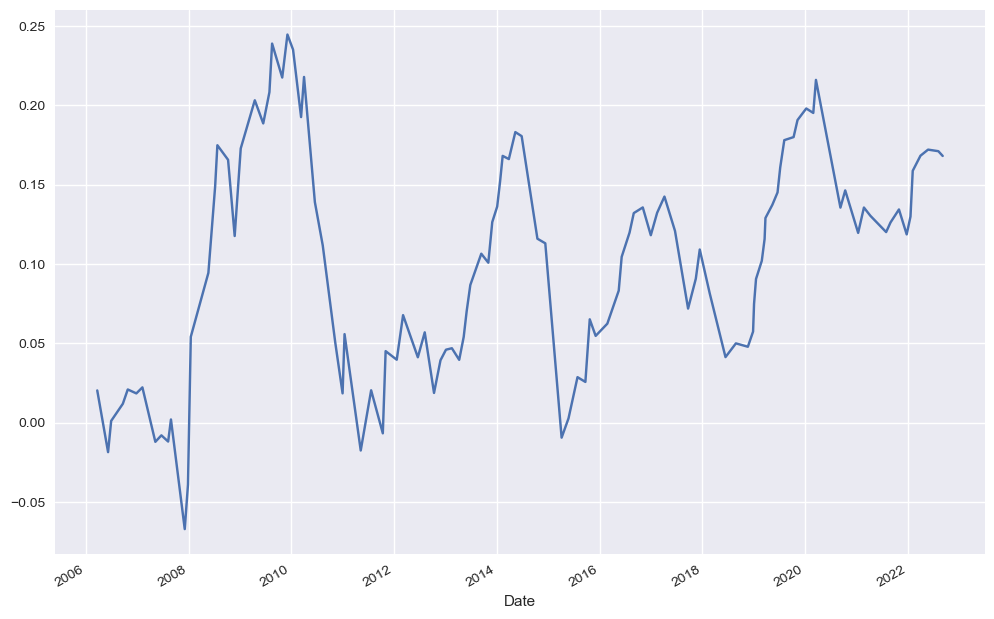

In [93]:
PnLdf["cumPnL"].plot(figsize=(12,8))